## Environment Settings


*   Connection to the drive folder
*   Import needed libraries



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
import os
import shutil
import json
import time
import gc
import torch
torch.manual_seed(42)
from IPython.display import clear_output 

!pip install git+https://github.com/openai/CLIP.git
import clip
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4w2gtbob
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4w2gtbob
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=27128589331b302b1f7c0a6e9e2902b682881d6081a8956113a74feb4a268496
  Stored in directory: /tmp/pip-ephem-wheel-cache-7chllsg3/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.0 MB/s eta 0:00:00
  Preparing me

## Unzip data


*   celebA dataset
*   flickr dataset
*   face2text dataset

Images are then divided among smaller folders sucha that each folder contains the same number of samples from each dataset

**NB:** to unzip files first add a shortcut to the home directory of your drive.



In [ ]:
!unzip '/content/drive/MyDrive/Vision & Perception Project/CelebA-Dialog (HQ)/image.zip' -d '/content/celebA/'
!unzip '/content/drive/MyDrive/Vision & Perception Project/flickrfaceshq-dataset-ffhq.zip' -d '/content/flickr'
!unzip '/content/drive/MyDrive/Vision & Perception Project/face2text.zip' 

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/flickr/49004.png  
  inflating: /content/flickr/49005.png  
  inflating: /content/flickr/49006.png  
  inflating: /content/flickr/49007.png  
  inflating: /content/flickr/49008.png  
  inflating: /content/flickr/49009.png  
  inflating: /content/flickr/49010.png  
  inflating: /content/flickr/49011.png  
  inflating: /content/flickr/49012.png  
  inflating: /content/flickr/49013.png  
  inflating: /content/flickr/49014.png  
  inflating: /content/flickr/49015.png  
  inflating: /content/flickr/49016.png  
  inflating: /content/flickr/49017.png  
  inflating: /content/flickr/49018.png  
  inflating: /content/flickr/49019.png  
  inflating: /content/flickr/49020.png  
  inflating: /content/flickr/49021.png  
  inflating: /content/flickr/49022.png  
  inflating: /content/flickr/49023.png  
  inflating: /content/flickr/49024.png  
  inflating: /content/flickr/49025.png  
  inflating: /content/flickr/49026.png  
  infla

In [ ]:
def moveElements(src1,src2):
  '''move images belonging to the two datasets imported into new folders.
  Each folder has 4700 samples in total, 2350 belonging to celebA and the other belonging to flickr.'''
  interval=len(os.listdir(src1))
  
  counter=0
  numDataset = 0
  lst1 = os.listdir(src1)
  lst2 = os.listdir(src2)
  
  for element in range(interval):
    if counter%4700==0 :
      numDataset += 1
      os.mkdir('/content/dataset'+str(numDataset))
      os.mkdir('/content/dataset{}/image'.format(str(numDataset)))
      dst = '/content/dataset{}/image/'.format(str(numDataset))

    el1, el2 = lst1[element], lst2[element]
    shutil.move(src1+el1, dst+str(counter)+el1[-4:])
    counter+=1
    shutil.move(src2+el2, dst+str(counter)+el2[-4:])
    counter+=1
     
moveElements('/content/celebA/image/','/content/flickr/')


## Dataset & Dataloader functions

*  define custom dataset for the captions
*  define a function to create a dataloader with any dataset

In [ ]:
class captionsDataset(Dataset):
    '''contains elements in the form {'encoded': a 127 elements tensor encoded throuugh CLIP, 'original': the text in atural langage}'''
    def __init__(self, device):
        self.captions = []
        self.model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
        self.device = device
        
    def obtainCaptions(self,path, interval=(0,17022)):
      with open(path,'r') as f:
        temp=f.readlines()
        for idx in range(interval[0],interval[1],1):
          try:
            start = temp[idx].find('"description": "')
            length=len('"description": "')
            end = temp[idx].find('"}\n')
            caption = temp[idx][start+length:end]
            self.embed(caption)
            del caption, start, end, length, 
          except RuntimeError:pass

    def embed(self, caption):
      with torch.no_grad():
        text = clip.tokenize(caption).to(self.device)
        text_features = self.model.encode_text(text)
        text_features = self.standardize(text_features)
        if ('man' in caption) or ('boy' in caption):
          text_features = text_features*3
        item = {'encoded':text_features,'original':caption}
        self.captions.append(item)
        del item, text_features, text

    def standardize(self,vector):
      temp=[]
      sum=0
      for idx in range(vector.shape[1]):
        if idx==0:
          sum*=vector[0][idx].item()
        elif idx%2==0:
          temp.append(sum)
          sum=vector[0][idx].item()
        else:
          sum*=vector[0][idx].item()
      temp = torch.tensor(temp)
      return temp

    def clear(self):
      self.captions = []
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        return self.captions[idx]


In [ ]:
def createDataloader(**kwargs):
  path = kwargs.get('path')
  batchSize = kwargs.get('batchSize')
  dataset = kwargs.get('data')
  if path is None and dataset is None:
    print('ERROR: you must specify a path or a dataset')
    return 
  
  if path is not None and dataset is not None:
    print('ERROR: you must specify just one between a path or a dataset')
    return 
  
  if batchSize is None:
    batchSize = 8
    print('WARNING: batsize updated to default value {}'.format(batchSize))

  if path is not None:
    dataset = dsets.ImageFolder(root = path ,
                            transform=transforms.Compose([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))

  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,shuffle=True, num_workers=2)
  return dataloader

## Model Definition
* weights' initialization
* generator's definition
* discriminator's definition
*function to inialize the gan for any type of training

In [ ]:
def weights_init(model):
  '''performs weight initialization on the model
  @param
  model: the NN that needs initialization'''

  layerName = model.__class__.__name__

  if layerName.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
    
  elif layerName.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)


In [ ]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, noiseSize, featureSize):
        super(Generator, self).__init__()

        self.currentEpoch=0

        self.conv1=nn.ConvTranspose2d(noiseSize,featureSize*8,kernel_size=4,stride=1,padding=0,bias=False)
        self.batchNorm1=nn.BatchNorm2d(featureSize*8)

        self.conv2=nn.ConvTranspose2d(featureSize*8, featureSize*4,kernel_size=4,stride=2,padding=1,bias=False)
        self.batchNorm2=nn.BatchNorm2d(featureSize*4)

        self.conv3=nn.ConvTranspose2d(featureSize*4, featureSize*2,kernel_size=4,stride=2,padding=1,bias=False)
        self.batchNorm3=nn.BatchNorm2d(featureSize*2)

        self.conv4=nn.ConvTranspose2d(featureSize*2,featureSize,kernel_size=4,stride=2,padding=1,bias=False)
        self.batchNorm4=nn.BatchNorm2d(featureSize)

        self.conv5=nn.ConvTranspose2d(featureSize,3,kernel_size=4,stride=2,padding=1,bias=False)
        
        self.tanh=nn.Tanh()
        self.relu=nn.ReLU()
        

    def forward(self, input):

        out=self.conv1(input)
        out=self.batchNorm1(out)
        out=self.relu(out)

        out=self.conv2(out)
        out=self.batchNorm2(out)
        out=self.relu(out)

        out=self.conv3(out)
        out=self.batchNorm3(out)
        out=self.relu(out)

        out=self.conv4(out)
        out=self.batchNorm4(out)
        out=self.relu(out)

        out=self.conv5(out)
        out=self.tanh(out)

        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels, featureSize):
        super(Discriminator,self).__init__()

        self.conv1=nn.Conv2d(channels,featureSize,4,2,1,bias=False)
        self.batchNorm1=nn.BatchNorm2d(featureSize)

        self.conv2=nn.Conv2d(featureSize,featureSize*2,4,2,1,bias=False)
        self.batchNorm2=nn.BatchNorm2d(featureSize*2)

        self.conv3=nn.Conv2d(featureSize*2,featureSize*4,4,2,1,bias=False)
        self.batchNorm3=nn.BatchNorm2d(featureSize*4)

        self.conv4=nn.Conv2d(featureSize*4,featureSize*8,4,2,1,bias=False)
        self.batchNorm4=nn.BatchNorm2d(featureSize*8)

        self.conv5=nn.Conv2d(featureSize*8,1,4,1,0,bias=False)

        self.leakyRelu= nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid=nn.Sigmoid()

    def forward(self, input):

        out=self.conv1(input)
        out=self.batchNorm1(out)
        out=self.leakyRelu(out)

        out=self.conv2(out)
        out=self.batchNorm2(out)
        out=self.leakyRelu(out)

        out=self.conv3(out)
        out=self.batchNorm3(out)
        out=self.leakyRelu(out)

        out=self.conv4(out)
        out=self.batchNorm4(out)
        out=self.leakyRelu(out)
        
        out=self.conv5(out)
        out=self.sigmoid(out)

        return out

In [ ]:
def initializeGan(device, path=None, path2 = None, mode='adversarial'):
  '''initialize the model for the training'''
  lr = 0.0002
  beta1 = 0.5
  inputSize = 256
  featureSize = 64
  channels = 3

  generator=Generator(inputSize,featureSize).to(device)
  nn.DataParallel(generator)
  generator.apply(weights_init)
  discriminator = Discriminator(channels,featureSize).to(device)
  nn.DataParallel(discriminator)
  discriminator.apply(weights_init)

  optimizerGen=optim.Adam(generator.parameters(),lr,betas=(beta1,0.999))
  optimizerDiscr=optim.Adam(discriminator.parameters(),lr,betas=(beta1,0.999))

  if path is None:
    return generator, discriminator, optimizerGen, optimizerDiscr
  elif mode=='adversarial':

    statedict=sorted(os.listdir(path))[-1]

    checkPoint=torch.load(path+'{}'.format(statedict),map_location=torch.device('cpu'))
    generator.load_state_dict(checkPoint['generator'])
    discriminator.load_state_dict(checkPoint['discriminator'])
    optimizerGen.load_state_dict(checkPoint['optGen'])
    optimizerDiscr.load_state_dict(checkPoint['optDiscr'])
    fixed_noise=checkPoint['fixedNoise'].to(device)
    lossG=checkPoint['genLoss'].tolist()
    lossD=checkPoint['discrLoss'].tolist()
    generator.currentEpoch=int(statedict.split('.')[0][11:])+1
    
    return generator, discriminator, optimizerGen, optimizerDiscr, fixed_noise, lossG, lossD#, cap

  elif mode=='CLIP':

    statedict=sorted(os.listdir(path))[-1]

    checkPoint=torch.load(path+'{}'.format(statedict),map_location=torch.device('cpu'))
    generator.load_state_dict(checkPoint['generator'])
    optimizerGen.load_state_dict(checkPoint['optGen'])
    fixed_noise=checkPoint['fixedNoise'].to(device)
    lossG=checkPoint['genLoss'].tolist()
    generator.currentEpoch=int(statedict.split('.')[0][11:])+1
    caption = 'A woman with high cheekbones, a defined jawline and a small nose. She has full lips and light-green eyes. She has blonde hair and is wearing makeup.'
    return generator, optimizerGen, lossG, fixed_noise, caption

  elif mode=='both':

    if path2==None:
      print('ERROR: you must specify a second path')
      return
    
    #import discriminator
    whichOne = 1 if int(os.listdir(path)[-1][11:-3])>int(os.listdir(path2)[-1][11:-3]) else 2  #to determine which checkpoint has he updated generator
    statedict=sorted(os.listdir(path))[-1]
    checkPoint=torch.load(path+'{}'.format(statedict),map_location=torch.device('cpu'))
    optimizerDiscr.load_state_dict(checkPoint['optDiscr'])
    lossD=checkPoint['discrLoss'].tolist()
    fixed_noise=checkPoint['fixedNoise'].to(device)
    caption = 'A woman with high cheekbones, a defined jawline and a small nose. She has full lips and light-green eyes. She has blonde hair and is wearing makeup.'
    
    if whichOne==2:

      statedict=sorted(os.listdir(path2))[-1]
      checkPoint=torch.load(path2+'{}'.format(statedict),map_location=torch.device('cpu'))
      noiseCaption=checkPoint['fixedNoise'].to(device)
    
    else:
      statedict2=sorted(os.listdir(path2))[-1]
      checkPoint2=torch.load(path2+'{}'.format(statedict2),map_location=torch.device('cpu'))
      noiseCaption=checkPoint2['fixedNoise'].to(device)
  
    generator.load_state_dict(checkPoint['generator'])
    optimizerGen.load_state_dict(checkPoint['optGen'])
    lossG=checkPoint['genLoss'].tolist()
    generator.currentEpoch=int(statedict.split('.')[0][11:])+1

    return generator, discriminator, optimizerGen, optimizerDiscr, fixed_noise, lossG, lossD, noiseCaption, caption


## Trainer definition 
* trainer definition for adversarial mode
* trainer definition for training with clip and captions

In [ ]:
class AdversarialTrainer():
  def __init__(self, device, generator, discriminator, optimizerGenerator, optimizerDiscriminator, **kwargs):
    '''Initialization'''
    self.generator = generator
    self.discriminator = discriminator
    self.optGen =  optimizerGenerator
    self.optDiscr = optimizerDiscriminator
    self.captions = kwargs.get('captions')
    self.evaluateNoise = kwargs.get('evaluateNoise')
    self.device = device

    print('Adversarial trainer initialized')

  def train(self, dataloader, loss=nn.BCELoss(), epochs=10, genLoss=[], discrLoss=[]):

    epochStart=self.generator.currentEpoch
    epochs+=epochStart
    noiseSize = 256

    print('Start training in adversarial mode...')
    
    for epoch in range(epochStart,epochs):
      gc.collect()
      torch.cuda.empty_cache()
      time.sleep(2)
      clear_output()

      batchLossGen=0
      batchLossDiscr=0
      self.generator.train()
      self.discriminator.train()
      #start the training
      for i,data in enumerate(dataloader,0):
        
        real = 1
        fake = 0
        batch = data[0].to(self.device)

        #train discriminator
        ##Train with real batch
        self.discriminator.zero_grad()
        batchSize = batch.shape[0]
        labels = torch.full((batchSize,),real,dtype=torch.float, device=self.device)
        out = self.discriminator(batch).view(-1)
        errorDiscrReal = loss(out,labels) 
        accuracyDiscr = self.computeAccuracy(out,labels)
        if i%2==0:errorDiscrReal.backward() #update the discriminator only if epoch number is even
        
        ##Train with fake batch
        noise = torch.randn(size=(batchSize,noiseSize, 1, 1),device=self.device)
        outGen = self.generator(noise)
        labels = labels.fill_(fake)
        outFinal = self.discriminator(outGen.detach()).view(-1)
        errorDiscrFake = loss(outFinal,labels)
        accuracyDiscr+= self.computeAccuracy(outFinal,labels)
        accuracyDiscr/=batchSize*2

        if i%2==0:errorDiscrFake.backward()
        errorDiscr = errorDiscrReal + errorDiscrFake
        if i%2==0:self.optDiscr.step()

        #Train generator
        self.generator.zero_grad()
        labels = labels.fill_(real)
        
        outFinal = self.discriminator(outGen).view(-1)
        errorGen = loss(outFinal,labels)
        accuracyGen = self.computeAccuracy(outFinal, labels)
        accuracyGen/=batchSize
        errorGen.backward()
        self.optGen.step()

        print('Epoch [{}/{}]\tBatch[{}/{}]'.format(str(epoch),str(epochs),str(i),len(dataloader)),'accuracyGen = {}, accuracyDiscr = {}'.format(str(accuracyGen),str(accuracyDiscr)),'lossGen = {}, lossDiscr = {}'.format(str(errorGen.item()),str(errorDiscr.item())))
        #Show images at runtime
        if (i % 100 == 0):
          with torch.no_grad():
            self.show(20,outGen.detach().cpu()) 
            self.evaluate(epoch)

        del batch, real, fake, errorDiscrFake, errorDiscrReal, labels, batchSize, outFinal, accuracyGen, accuracyDiscr
        
        #append errors to the batchLoss lists
        batchLossGen += errorGen.item()
        batchLossDiscr += errorDiscr.item()
      
      #Save epoch's data
      self.generator.currentEpoch+=1
      genLoss.append(batchLossGen/len(dataloader))
      discrLoss.append(batchLossDiscr/len(dataloader))
      torch.save(
          {'generator': self.generator.state_dict(),
          'discriminator':self.discriminator.state_dict(),
          'optGen': self.optGen.state_dict(),
          'optDiscr': self.optDiscr.state_dict(),
          'fixedNoise': self.evaluateNoise,
          'genLoss':torch.tensor(genLoss),
          'discrLoss':torch.tensor(discrLoss)},'/content/drive/MyDrive/Vision & Perception Project/AdversarialTrainEpochs/stateDicts_{}.pt'.format(str(epoch)))
      
      self.evaluate(epoch,save=True)
      del batchLossGen, batchLossDiscr

    return genLoss, discrLoss
  
  def generate(self, input):
    '''evaluate the generator over a fixed noise'''
    with torch.no_grad():
      self.generator.eval()
      output = self.generator(input).detach().cpu()
      return output

  def evaluate(self,epoch,save=False):
    '''evaluate the generator over a fixed noise'''
    with torch.no_grad():
      self.generator.eval()
      self.discriminator.eval()
      evaluate = self.generator(self.evaluateNoise).detach().cpu()
      if save:self.show(10,evaluate, save=str(epoch))
      else:
        self.show(10,evaluate)
      del evaluate
      self.generator.train()
      self.discriminator.train()

  def computeAccuracy(self,output,labels):
    '''compute the accuracy over the given batch
    @param
    output: output of the discriminator
    labels: ground truth values
    @return: accuracy value for the given batch'''
    accuracy=0
    out=output.tolist()
    lab=labels.tolist()
    for el1,el2 in zip(out,lab):
      if round(el1)==el2:
        accuracy+=1
    del out,lab
    return accuracy

  def show(self, size,images,save=''):
    '''display images at runtime and save it at the end of each epoch
    @param
    size: size of the plt figure
    images: tensor containing the images that should be displayed
    save(optional): if different from False it's the nuber of epoch used to save the image
    '''
    plt.figure(figsize=(size,size))
    plt.axis("off")
    plt.title("Fake Image")
    plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True),(1,2,0)))
    if save!='': 
      plt.savefig('/content/drive/MyDrive/Vision & Perception Project/AdversarialTrainImages/epoch{}.jpg'.format(save))
    plt.show()



In [ ]:
class TrainerWithClip():
  def __init__(self, device, generator, optimizerGenerator, **kwargs):
    '''Initialization'''
    self.generator = generator
    self.optGen =  optimizerGenerator
    self.captions = kwargs.get('captions')
    self.evaluateNoise = kwargs.get('evaluateNoise')
    self.device = device
    #Import CLIP model
    self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    print('Clip trainer initialized')

  def train(self, dataloader, epochs=10, genLoss=[]):

    epochStart=self.generator.currentEpoch
    epochs+=epochStart
    noiseSize = 256

    print('start training with clip')
    
    for epoch in range(epochStart,epochs):
      gc.collect()
      torch.cuda.empty_cache()
      time.sleep(2)
      clear_output()

      batchLossGen=0
      self.generator.train()
        
      for i,data in enumerate(dataloader,0):
        
        #Get data
        batch = self.getNoise(data['encoded'].clone(),noiseSize).to(self.device)#torch.randn(size=(batchSize,noiseSize, 1, 1),device=self.device)#.float()
        captions = data['original']
        batchSize = batch.shape[0]

        #Train generator
        self.generator.zero_grad()
        outGen = self.generator(batch)
        output = outGen.clone().detach().cpu()
        errorGen = self.getSimilarity(outGen,captions)*10
        errorGen.backward()
        self.optGen.step()

        print('Epoch [{}/{}]\tBatch[{}/{}]\tlossGen = {}'.format(str(epoch),str(epochs),str(i),len(dataloader),str(errorGen.item())))

        #Show image
        if (i % 100 == 0):
          with torch.no_grad():
            self.show(10,output,data['original']) 
            self.evaluate(epoch)
        
        del batch, batchSize, outGen
        batchLossGen += errorGen.item()
        
      self.generator.currentEpoch+=1
      genLoss.append(batchLossGen/len(dataloader))
      torch.save(
          {'generator': self.generator.state_dict(),
          'optGen': self.optGen.state_dict(),
          'fixedNoise': self.evaluateNoise['encoded'],
          'genLoss':torch.tensor(genLoss)},'/content/drive/MyDrive/Vision & Perception Project/ClipTrainEpochs/stateDicts_{}.pt'.format(str(epoch)))
      
      self.evaluate(epoch,save=True)
      del batchLossGen

    return genLoss
  
  def getSimilarity(self,output, captions):
    '''compute similarity score using CLIP. 
    It evaluates the similarity with three diferent texts, 
    one is the caption associated to the image, 
    the other two are used to give uncertanty to Clip newtwork
    @param
    output: images generated by the generator
    captions: list of captions associated to the images'''
    loss = [0]
    for idx in range(output.shape[0]):
      img = output[idx]
      caption = captions[idx]
      inputs = self.processor(text=["a man","a woman", caption], images=img, return_tensors="pt", padding=True)
      outputs = self.model(**inputs)
      logits_per_image = outputs.logits_per_image  # this is the image-text similarity score for each text given
      probs = logits_per_image.softmax(dim=1)[0][-1].item() # this is the image-text similarity score of interest
      loss[0] += 1-probs
    del probs,logits_per_image,outputs,inputs,caption,img
    loss = torch.tensor(loss,device = self.device, requires_grad=True)
    return loss


  def getNoise(self, captions, noiseSize):
    '''attach random noise to a caption
    The result is a vector of size batchSize x  noiseSize (8x256) with mean and standard deviation equal to one '''
    temp=[]
    first = True
    for element in captions:
      element=element.view(1,element.shape[0])
      noise = torch.randn(size=(1,noiseSize-element.shape[1]))
      noise = torch.cat((noise,element),1)
      noise.to(self.device)
      mean=torch.mean(noise)
      std=torch.std(noise)
      noise = (noise-mean)/std
      if first:
        temp=noise
        first=False
      else:
        temp = torch.cat((temp,noise),0)
      del noise, mean, std, element
    temp = temp.view(temp.shape[0],temp.shape[1],1,1)
    return temp
    
  def evaluate(self,epoch,save=False):
    '''evaluate the generator over a fixed noise'''
    with torch.no_grad():
      self.generator.eval()
      evaluate = self.generator(self.evaluateNoise['encoded']).detach().cpu()
      errorGen = self.getSimilarity(evaluate,self.evaluateNoise['original'])
      if save:self.show(10,evaluate, self.evaluateNoise['original'], save=str(epoch))
      else:
        self.show(10,evaluate,self.evaluateNoise['original']+'loss = '+str(errorGen.item()))
      del evaluate
      self.generator.train(True)
  
  def show(self, size, images, captions, save=''):
    '''display images at runtime
    @param
    size: size of the plt figure
    images: tensor containing the images that should be displayed
    captions: list of natural language captions associated each to an image in images
    save(optional): if different from False it's the nuber of epoch used to save the image
    '''
    plt.figure(figsize=(size,size))
    plt.axis("off")
    plt.title('Training with Clip')
    if type(captions)!=list:
      plt.title(captions)
    else:
      for caption in captions:
        print(caption)
    plt.imshow(np.transpose(vutils.make_grid(images, padding=0, normalize=True),(1,2,0)))
    if save!='': 
      plt.savefig('/content/drive/MyDrive/Vision & Perception Project/ClipTrainImages/epoch{}.jpg'.format(save))
    plt.show()



## Start training
the function *startTraining* is able to start any kind of training.
It is possible to train in three different modalities:
* adversarial \
  It trains both generator and discriminator together.
* clip \
  It train with caption, using clip to get the similarity score between a generated image and a given caption. It trains only the generator.
* both \
  It first start a training loop in clip modality, followed by a training loop in advesarial mode.

It is also possible to choose the number of epochs, the size of the batch and the number of mini-datasets on which you would ike to iterate.

Epoch [268/269]	Batch[0/1000]	lossGen = 2.5458030700683594
A young woman with blonde hair and dark roots. Her eyes are dark-coloured and there is some make-up around them. Her lips are heart-shaped.


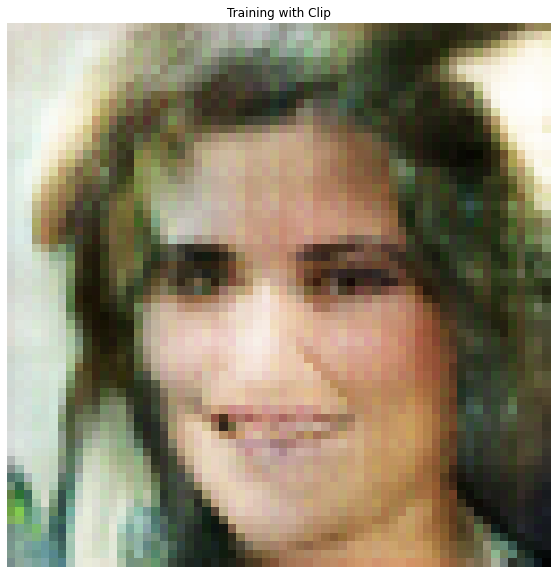

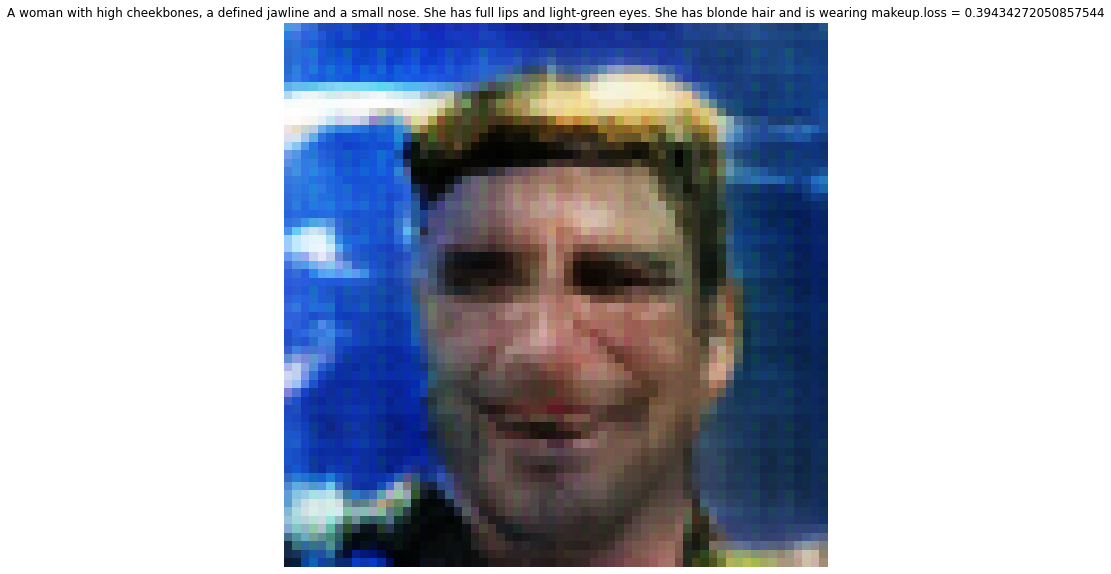

Epoch [268/269]	Batch[1/1000]	lossGen = 0.9036052227020264
Epoch [268/269]	Batch[2/1000]	lossGen = 2.3043198585510254
Epoch [268/269]	Batch[3/1000]	lossGen = 9.994735717773438
Epoch [268/269]	Batch[4/1000]	lossGen = 0.920860767364502
Epoch [268/269]	Batch[5/1000]	lossGen = 3.064934730529785
Epoch [268/269]	Batch[6/1000]	lossGen = 6.005141735076904
Epoch [268/269]	Batch[7/1000]	lossGen = 3.756816864013672
Epoch [268/269]	Batch[8/1000]	lossGen = 1.355055570602417
Epoch [268/269]	Batch[9/1000]	lossGen = 5.923427581787109
Epoch [268/269]	Batch[10/1000]	lossGen = 8.835689544677734
Epoch [268/269]	Batch[11/1000]	lossGen = 1.1370879411697388
Epoch [268/269]	Batch[12/1000]	lossGen = 9.832650184631348
Epoch [268/269]	Batch[13/1000]	lossGen = 5.424870491027832
Epoch [268/269]	Batch[14/1000]	lossGen = 4.6536760330200195
Epoch [268/269]	Batch[15/1000]	lossGen = 4.763426780700684
Epoch [268/269]	Batch[16/1000]	lossGen = 8.256335258483887
Epoch [268/269]	Batch[17/1000]	lossGen = 0.7700395584106445
E

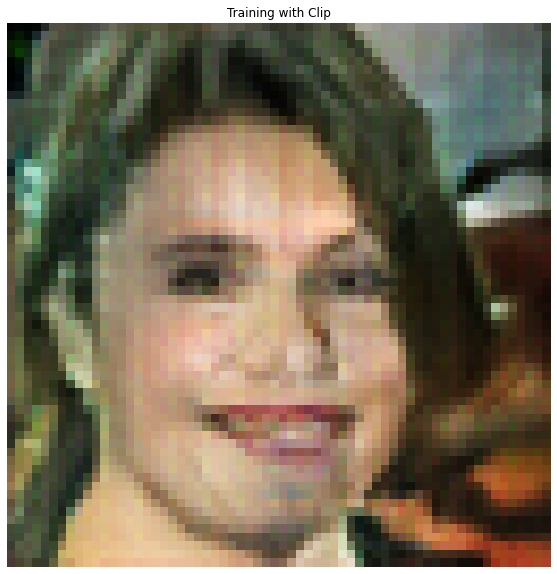

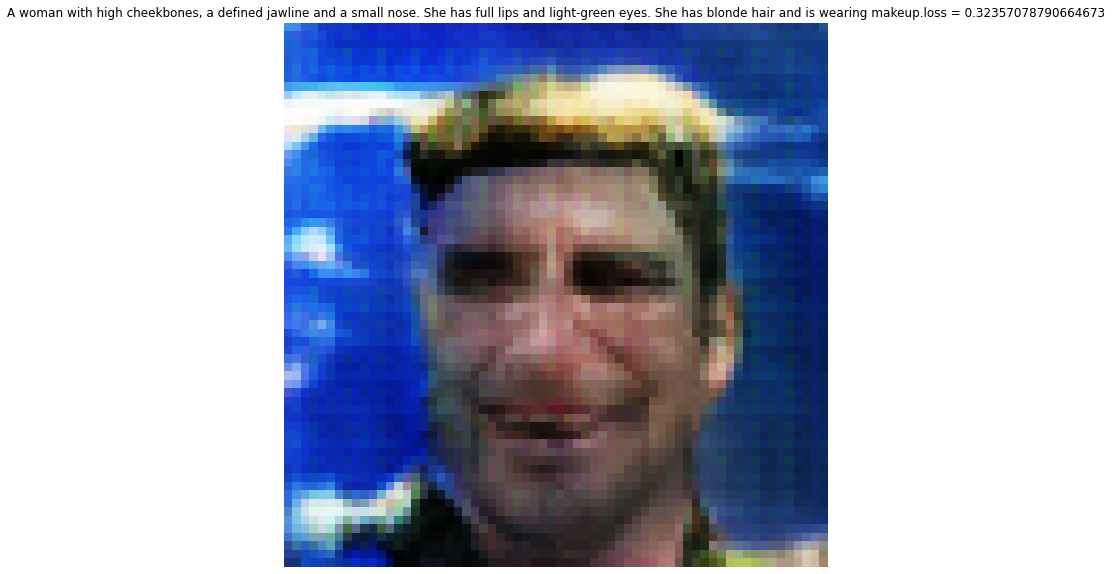

Epoch [268/269]	Batch[101/1000]	lossGen = 9.384577751159668
Epoch [268/269]	Batch[102/1000]	lossGen = 6.295795440673828
Epoch [268/269]	Batch[103/1000]	lossGen = 8.972878456115723
Epoch [268/269]	Batch[104/1000]	lossGen = 2.655508518218994
Epoch [268/269]	Batch[105/1000]	lossGen = 5.941614627838135
Epoch [268/269]	Batch[106/1000]	lossGen = 1.7397487163543701
Epoch [268/269]	Batch[107/1000]	lossGen = 5.77269172668457
Epoch [268/269]	Batch[108/1000]	lossGen = 9.820745468139648
Epoch [268/269]	Batch[109/1000]	lossGen = 1.1528569459915161
Epoch [268/269]	Batch[110/1000]	lossGen = 9.949361801147461
Epoch [268/269]	Batch[111/1000]	lossGen = 2.554088830947876
Epoch [268/269]	Batch[112/1000]	lossGen = 5.401804447174072
Epoch [268/269]	Batch[113/1000]	lossGen = 2.4954986572265625
Epoch [268/269]	Batch[114/1000]	lossGen = 9.177286148071289
Epoch [268/269]	Batch[115/1000]	lossGen = 9.146817207336426
Epoch [268/269]	Batch[116/1000]	lossGen = 9.733089447021484
Epoch [268/269]	Batch[117/1000]	lossGe

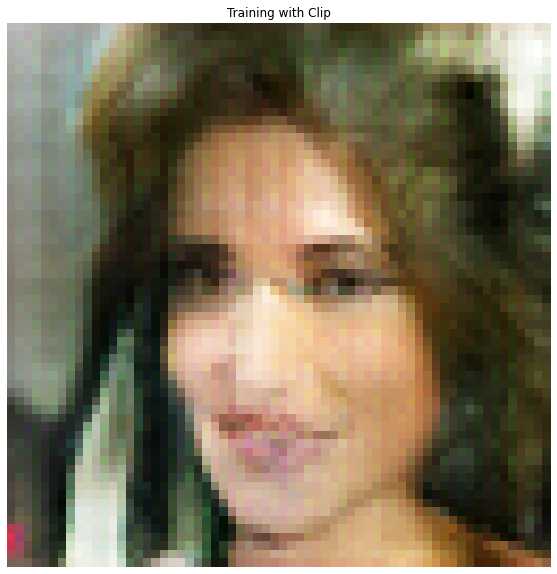

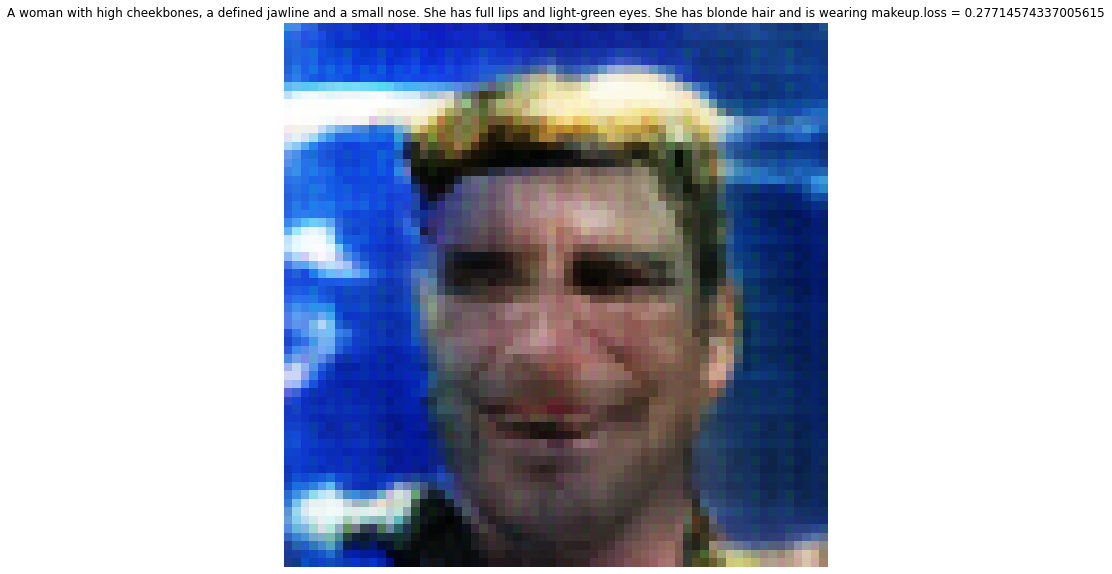

Epoch [268/269]	Batch[201/1000]	lossGen = 4.156370162963867
Epoch [268/269]	Batch[202/1000]	lossGen = 7.925148963928223
Epoch [268/269]	Batch[203/1000]	lossGen = 6.7124152183532715
Epoch [268/269]	Batch[204/1000]	lossGen = 7.74840784072876
Epoch [268/269]	Batch[205/1000]	lossGen = 9.572879791259766
Epoch [268/269]	Batch[206/1000]	lossGen = 2.01054048538208
Epoch [268/269]	Batch[207/1000]	lossGen = 6.845992088317871
Epoch [268/269]	Batch[208/1000]	lossGen = 8.360411643981934
Epoch [268/269]	Batch[209/1000]	lossGen = 9.694334983825684
Epoch [268/269]	Batch[210/1000]	lossGen = 3.2691783905029297
Epoch [268/269]	Batch[211/1000]	lossGen = 8.258752822875977
Epoch [268/269]	Batch[212/1000]	lossGen = 3.382267475128174
Epoch [268/269]	Batch[213/1000]	lossGen = 4.751743793487549
Epoch [268/269]	Batch[214/1000]	lossGen = 9.112092971801758
Epoch [268/269]	Batch[215/1000]	lossGen = 0.9466379880905151
Epoch [268/269]	Batch[216/1000]	lossGen = 9.095727920532227
Epoch [268/269]	Batch[217/1000]	lossGen

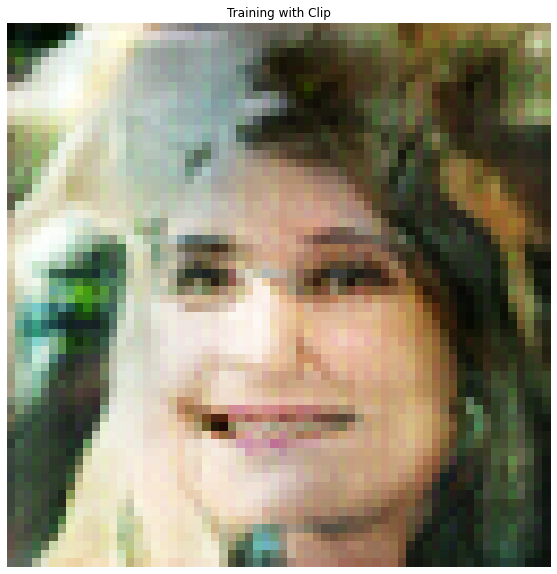

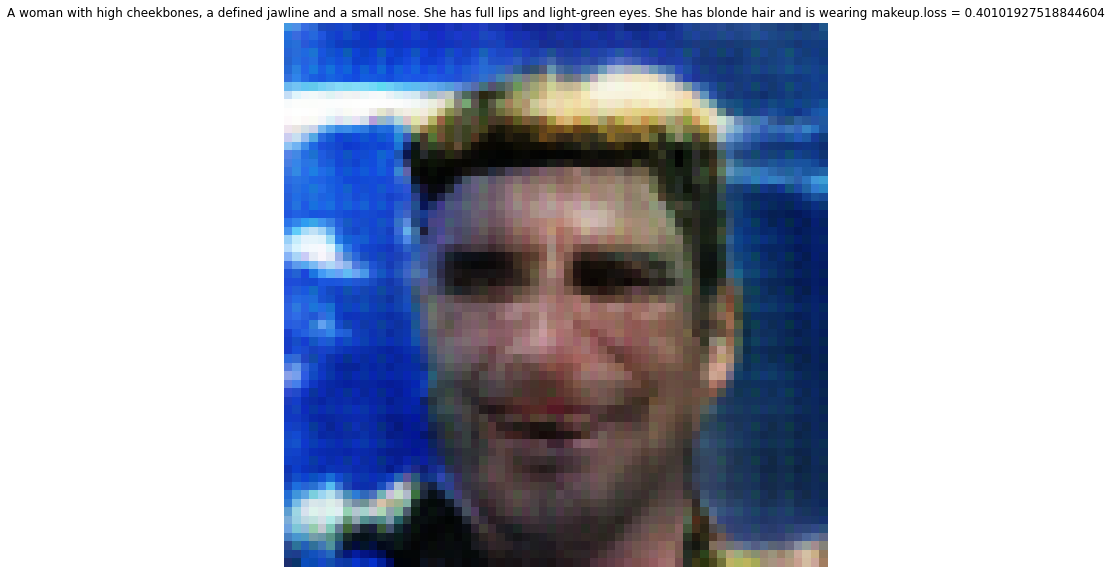

Epoch [268/269]	Batch[301/1000]	lossGen = 1.7597383260726929
Epoch [268/269]	Batch[302/1000]	lossGen = 1.3993799686431885
Epoch [268/269]	Batch[303/1000]	lossGen = 9.826038360595703
Epoch [268/269]	Batch[304/1000]	lossGen = 8.844829559326172
Epoch [268/269]	Batch[305/1000]	lossGen = 3.7015485763549805
Epoch [268/269]	Batch[306/1000]	lossGen = 9.41940689086914
Epoch [268/269]	Batch[307/1000]	lossGen = 5.178057670593262
Epoch [268/269]	Batch[308/1000]	lossGen = 9.56683349609375
Epoch [268/269]	Batch[309/1000]	lossGen = 9.665109634399414
Epoch [268/269]	Batch[310/1000]	lossGen = 1.2094742059707642
Epoch [268/269]	Batch[311/1000]	lossGen = 9.900301933288574
Epoch [268/269]	Batch[312/1000]	lossGen = 8.841440200805664
Epoch [268/269]	Batch[313/1000]	lossGen = 3.465764045715332
Epoch [268/269]	Batch[314/1000]	lossGen = 8.894018173217773
Epoch [268/269]	Batch[315/1000]	lossGen = 9.781556129455566
Epoch [268/269]	Batch[316/1000]	lossGen = 7.074069976806641
Epoch [268/269]	Batch[317/1000]	lossGe

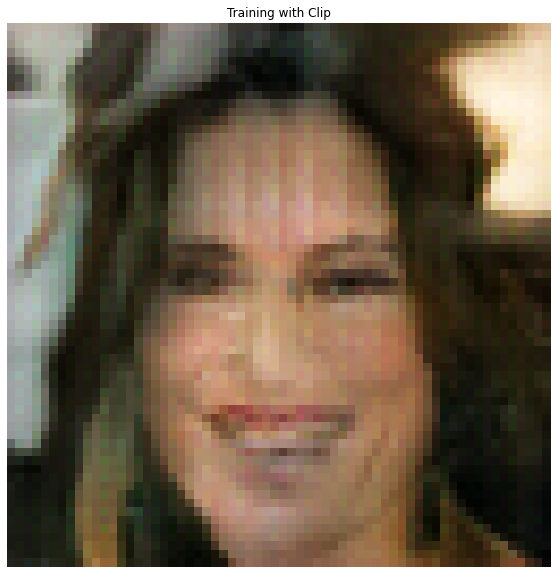

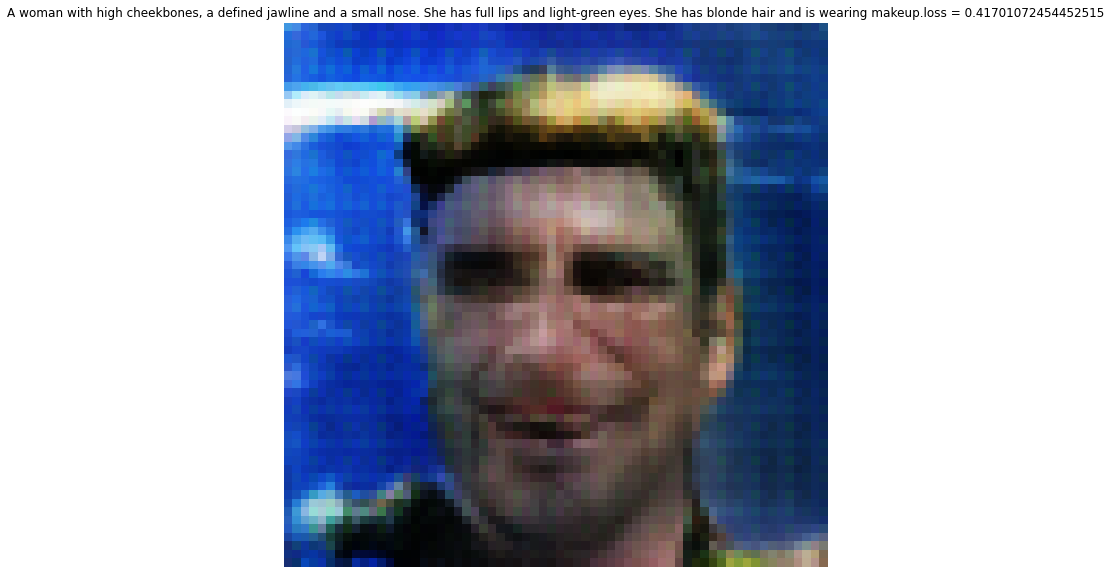

Epoch [268/269]	Batch[401/1000]	lossGen = 3.842447280883789
Epoch [268/269]	Batch[402/1000]	lossGen = 7.4929704666137695
Epoch [268/269]	Batch[403/1000]	lossGen = 9.777384757995605
Epoch [268/269]	Batch[404/1000]	lossGen = 3.171924352645874
Epoch [268/269]	Batch[405/1000]	lossGen = 6.076626777648926
Epoch [268/269]	Batch[406/1000]	lossGen = 9.634475708007812
Epoch [268/269]	Batch[407/1000]	lossGen = 8.618977546691895
Epoch [268/269]	Batch[408/1000]	lossGen = 7.902569770812988
Epoch [268/269]	Batch[409/1000]	lossGen = 9.12558650970459
Epoch [268/269]	Batch[410/1000]	lossGen = 7.7648115158081055
Epoch [268/269]	Batch[411/1000]	lossGen = 7.991750717163086
Epoch [268/269]	Batch[412/1000]	lossGen = 7.882511615753174
Epoch [268/269]	Batch[413/1000]	lossGen = 8.869467735290527
Epoch [268/269]	Batch[414/1000]	lossGen = 9.834917068481445
Epoch [268/269]	Batch[415/1000]	lossGen = 9.009977340698242
Epoch [268/269]	Batch[416/1000]	lossGen = 6.199543476104736
Epoch [268/269]	Batch[417/1000]	lossGen

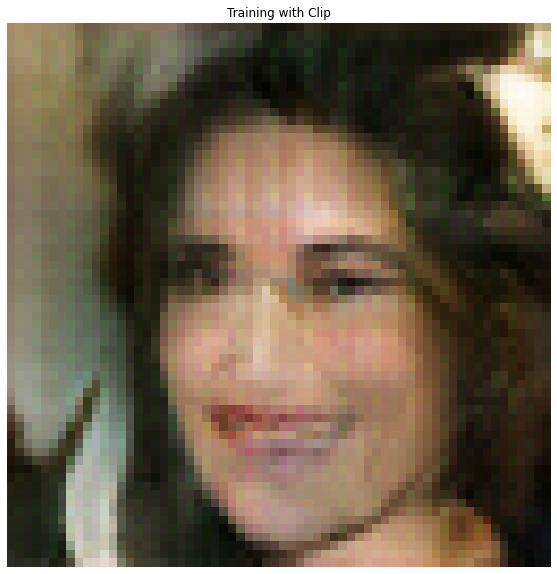

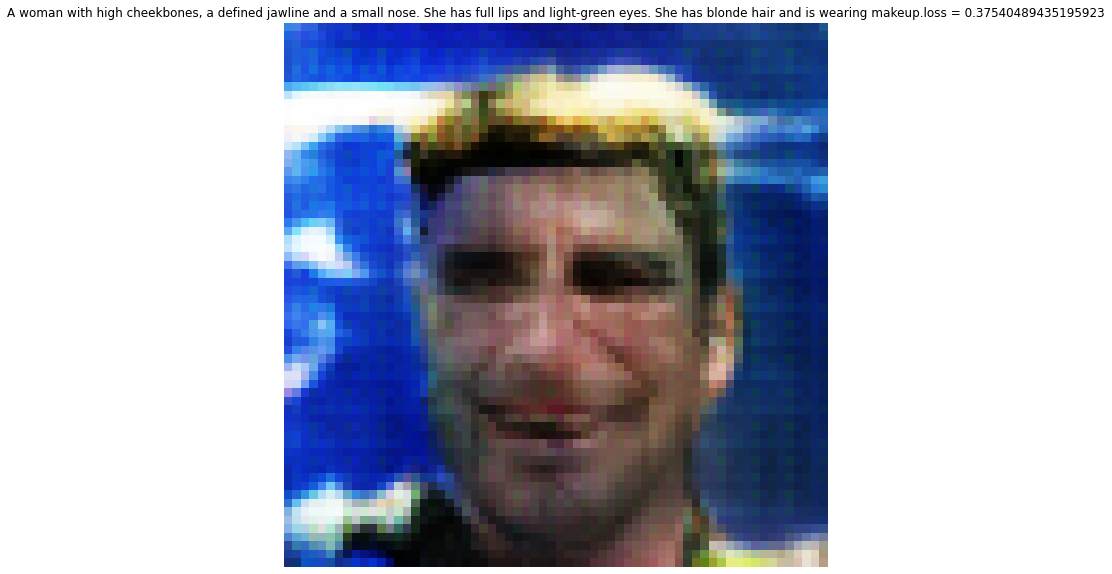

Epoch [268/269]	Batch[501/1000]	lossGen = 8.366643905639648
Epoch [268/269]	Batch[502/1000]	lossGen = 8.244303703308105
Epoch [268/269]	Batch[503/1000]	lossGen = 9.393447875976562
Epoch [268/269]	Batch[504/1000]	lossGen = 2.685901641845703
Epoch [268/269]	Batch[505/1000]	lossGen = 9.391919136047363
Epoch [268/269]	Batch[506/1000]	lossGen = 9.01720142364502
Epoch [268/269]	Batch[507/1000]	lossGen = 9.333908081054688
Epoch [268/269]	Batch[508/1000]	lossGen = 9.860734939575195
Epoch [268/269]	Batch[509/1000]	lossGen = 9.757579803466797
Epoch [268/269]	Batch[510/1000]	lossGen = 5.867858409881592
Epoch [268/269]	Batch[511/1000]	lossGen = 2.1009790897369385
Epoch [268/269]	Batch[512/1000]	lossGen = 6.242420673370361
Epoch [268/269]	Batch[513/1000]	lossGen = 8.993532180786133
Epoch [268/269]	Batch[514/1000]	lossGen = 9.956746101379395
Epoch [268/269]	Batch[515/1000]	lossGen = 1.8049955368041992
Epoch [268/269]	Batch[516/1000]	lossGen = 0.3061586618423462
Epoch [268/269]	Batch[517/1000]	lossGe

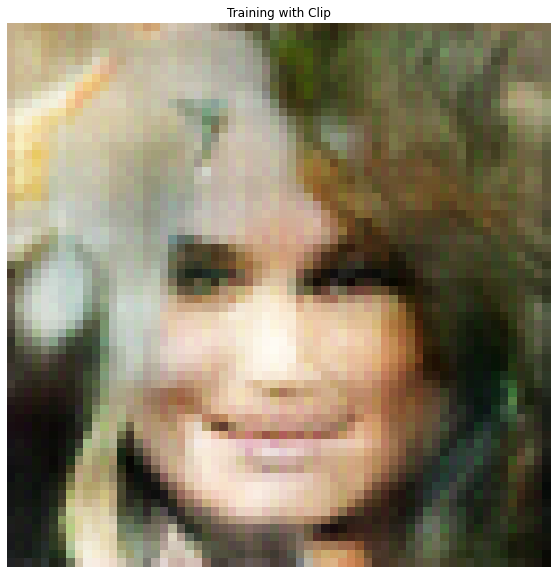

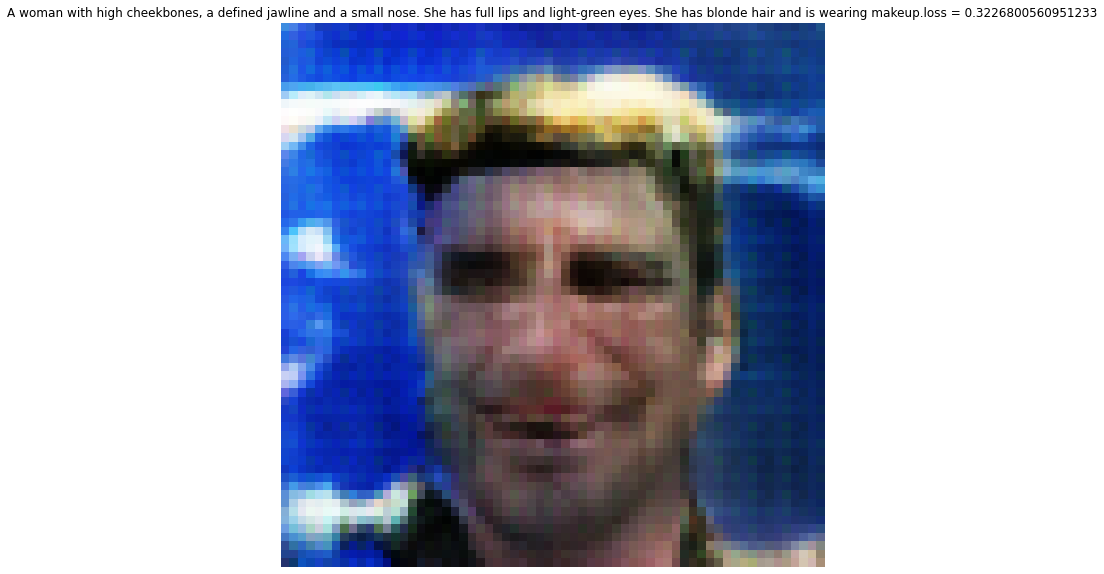

Epoch [268/269]	Batch[601/1000]	lossGen = 6.3828206062316895
Epoch [268/269]	Batch[602/1000]	lossGen = 8.352768898010254
Epoch [268/269]	Batch[603/1000]	lossGen = 9.602970123291016
Epoch [268/269]	Batch[604/1000]	lossGen = 5.346489906311035
Epoch [268/269]	Batch[605/1000]	lossGen = 7.01551628112793
Epoch [268/269]	Batch[606/1000]	lossGen = 3.5067880153656006
Epoch [268/269]	Batch[607/1000]	lossGen = 7.585241794586182
Epoch [268/269]	Batch[608/1000]	lossGen = 7.437754154205322
Epoch [268/269]	Batch[609/1000]	lossGen = 4.332330226898193
Epoch [268/269]	Batch[610/1000]	lossGen = 9.069448471069336
Epoch [268/269]	Batch[611/1000]	lossGen = 8.168128967285156
Epoch [268/269]	Batch[612/1000]	lossGen = 7.965513229370117
Epoch [268/269]	Batch[613/1000]	lossGen = 9.229180335998535
Epoch [268/269]	Batch[614/1000]	lossGen = 9.302037239074707
Epoch [268/269]	Batch[615/1000]	lossGen = 9.737250328063965
Epoch [268/269]	Batch[616/1000]	lossGen = 1.2985354661941528
Epoch [268/269]	Batch[617/1000]	lossGe

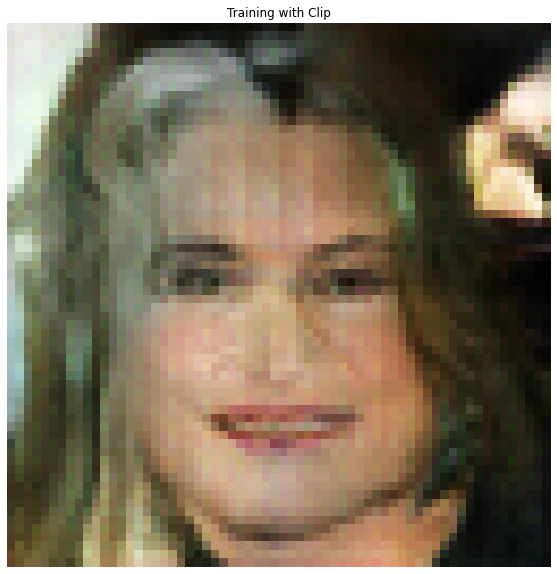

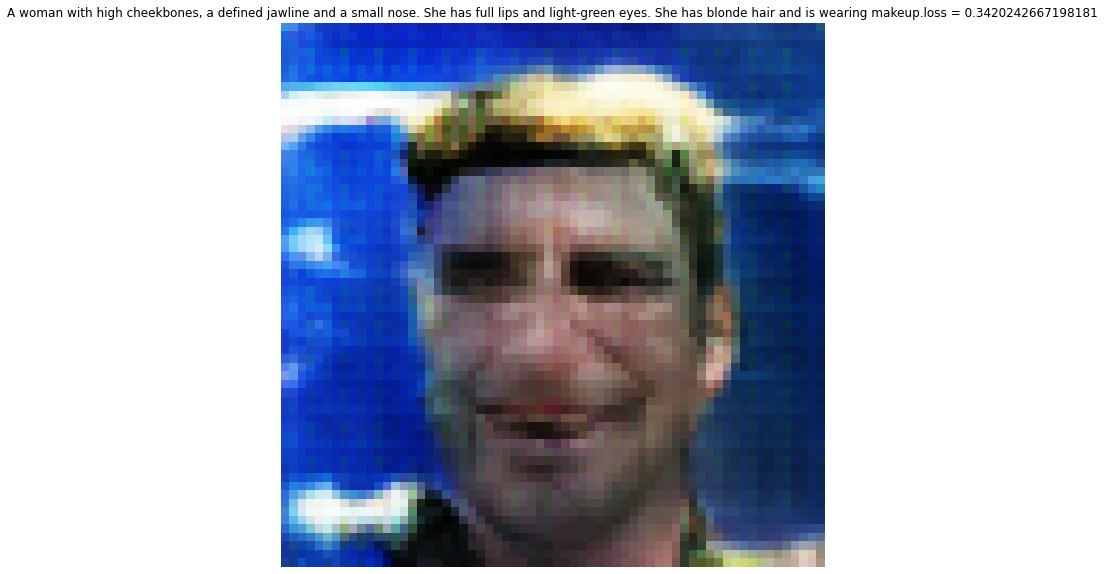

Epoch [268/269]	Batch[701/1000]	lossGen = 8.783089637756348
Epoch [268/269]	Batch[702/1000]	lossGen = 3.496976375579834
Epoch [268/269]	Batch[703/1000]	lossGen = 8.072868347167969
Epoch [268/269]	Batch[704/1000]	lossGen = 1.015210747718811
Epoch [268/269]	Batch[705/1000]	lossGen = 6.705316543579102
Epoch [268/269]	Batch[706/1000]	lossGen = 4.620584964752197
Epoch [268/269]	Batch[707/1000]	lossGen = 7.914838790893555
Epoch [268/269]	Batch[708/1000]	lossGen = 7.501285076141357
Epoch [268/269]	Batch[709/1000]	lossGen = 2.455836534500122
Epoch [268/269]	Batch[710/1000]	lossGen = 8.286474227905273
Epoch [268/269]	Batch[711/1000]	lossGen = 9.930195808410645
Epoch [268/269]	Batch[712/1000]	lossGen = 6.987724781036377
Epoch [268/269]	Batch[713/1000]	lossGen = 8.375408172607422
Epoch [268/269]	Batch[714/1000]	lossGen = 5.293503284454346
Epoch [268/269]	Batch[715/1000]	lossGen = 7.511256217956543
Epoch [268/269]	Batch[716/1000]	lossGen = 2.240018367767334
Epoch [268/269]	Batch[717/1000]	lossGen 

In [ ]:
def startTraining(epochs=5, batchSize=None, modality='both', nDatasets=1):
  '''start any training
  @param
  epochs: number of epochs, default is 5
  batchSize: size of batch, default is 8 for adversarial training and 1 for training with clip
  modality: training's modality {both, adversarial, clip}
  nDatasets: number of datasets on which you'd like to iterate. Default is 1'''

  gc.collect()
  netG, netD, optG, optD = initializeGan(device)
  netG, netD, optG, optD, noiseAdversarial, lossG, lossD, noise, caption = initializeGan(device,path='/content/drive/MyDrive/Vision & Perception Project/AdversarialTrainEpochs/',path2='/content/drive/MyDrive/Vision & Perception Project/ClipTrainEpochs/',mode='both')
  print('modality chosen: {}\tuploaded epoch: {}'.format(modality,netG.currentEpoch))

  if modality=='adversarial':
    #train in adversarial mode only
    size = batchSize if batchSize!=None else 8
    pathDataset = '/content/dataset0'
    trainer = AdversarialTrainer(device, netG, netD, optG, optD, evaluateNoise=noiseAdversarial)

    while nDatasets>0:
      try:
        pathDataset = pathDataset[:16] + str(nDatasets)
        dataloaderAdversarial = createDataloader(path=pathDataset, batchSize=size)
        lossG, lossD = trainer.train(dataloaderAdversarial, epochs=epochs, genLoss=lossG, discrLoss=lossD)
      except FileNotFoundError:
        nDatasets-=1

  elif modality=='clip':
    #train with only clip
    size = batchSize if batchSize!=None else 1
    fixed_noise = {'encoded':noise,'original':caption}
    pathCaptions = '/content/raw_2.0.jsonl'
    datasetCaptions = captionsDataset(device)
    trainer = TrainerWithClip(device, netG, optG, evaluateNoise=fixed_noise)

    for startIdx in range(0,20000,1000):
      if nDatasets<=0: return
      endIdx = startIdx+1000 if startIdx+1000<17022 else 17022
      datasetCaptions.clear()
      datasetCaptions.obtainCaptions(pathCaptions, interval=(startIdx,endIdx))
      dataloader = createDataloader(data=datasetCaptions, batchSize=1)
      lossG = trainer.train(dataloader, epochs=epochs, genLoss=lossG)
      nDatasets-=1

  elif modality=='both':
    #train in both modalities, first with clip and then in adversarial mode using the same number of epochs. 
    #batch size here can't be chosen
    noiseClip = {'encoded':noise,'original':caption}
    pathDataset = '/content/dataset0'
    pathCaptions =  '/content/raw_2.0.jsonl'
    datasetCaptions = captionsDataset(device)
    trainerAdversarial = AdversarialTrainer(device, netG, netD, optG, optD, evaluateNoise=noiseAdversarial)
    trainerCaptions = TrainerWithClip(device, netG, optG, evaluateNoise=noiseClip)

    for startIdx in range(0,20000,1000):
      if nDatasets<=0: return
      endIdx = startIdx+1000 if startIdx+1000<17022 else 17022
      datasetCaptions.clear()
      datasetCaptions.obtainCaptions(pathCaptions, interval=(startIdx,endIdx))
      dataloaderCaptions = createDataloader(data=datasetCaptions, batchSize=1)
      lossG = trainerCaptions.train(dataloaderCaptions, epochs=epochs, genLoss=lossG)
  
      try:
        pathDataset = pathDataset[:16] + str(nDatasets)
        dataloaderAdversarial = createDataloader(path=pathDataset, batchSize=8)
        lossG, lossD = trainerAdversarial.train(dataloaderAdversarial, epochs=epochs, genLoss=lossG, discrLoss=lossD)
      except FileNotFoundError:
        nDatasets-=1

startTraining(epochs=10,modality='clip',nDatasets=10)


## Generate
the function generate produce any image.
It needs as input a name and a description of the character that you would like to generate. It works looping on the generated image, if it does not match the given caption it update the text embedding by adding to it a random noise and pass it again to the generator. It does not get stuck in an infinite loop since the trshold for the similarity score is decreased if results are not reached after a fixed numer off iterations. 


generator uploaded at epoch: 268
generating Harry Potter
A young white man with untidy black hair. He has green eyes, and a lightning bolt-shaped scar on his forehead. He has a thin face and wears round glasses


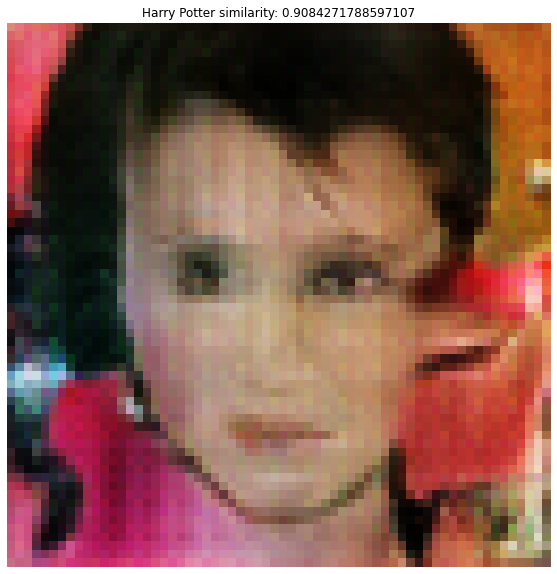

generator uploaded at epoch: 268
generating Gideon de Villiers
A young white man with black, curly hair. He has bright green eyes and a straight nose.


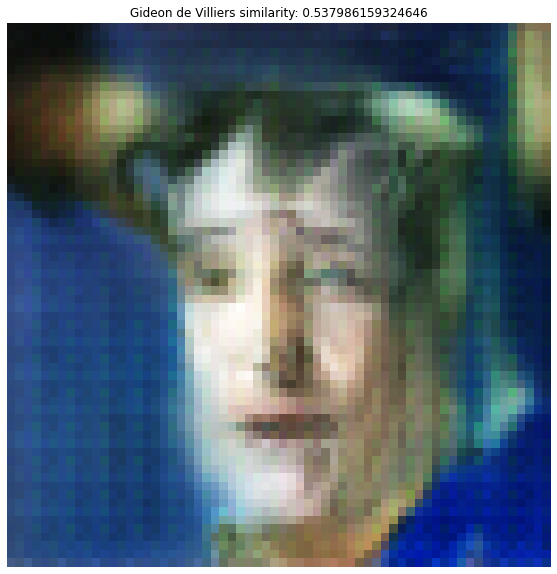

generator uploaded at epoch: 268
generating Hermione Granger
A young white girl. She has frizzy, brown hair. She has brown eyes, and  protruding teeth.


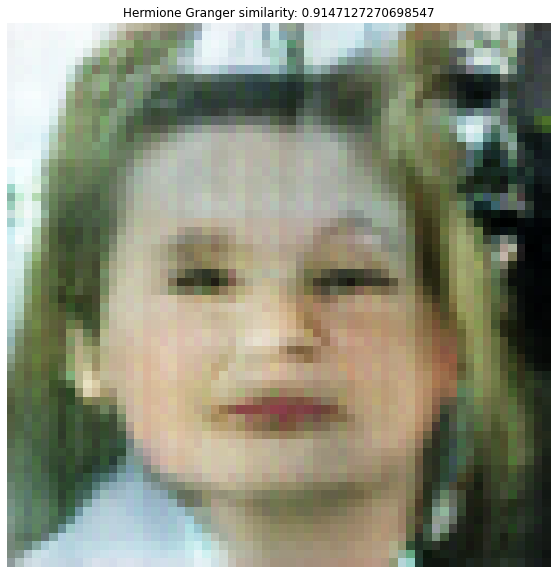

generator uploaded at epoch: 268
generating John Coffey
a black afro-american man. He is really tall and large, with a powerful muscular frame.


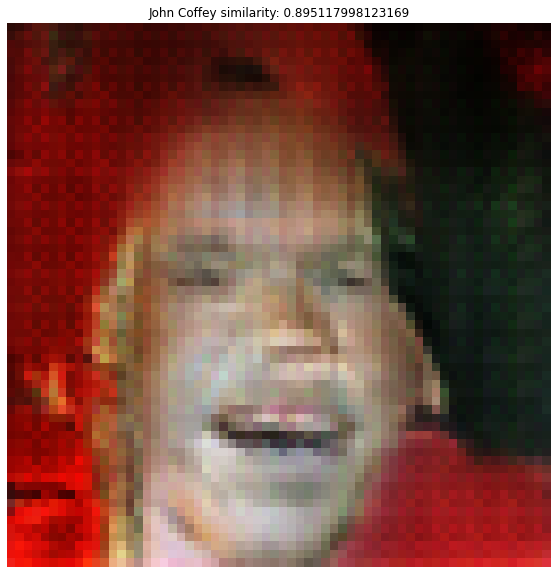

In [ ]:
def generate(name, description, device):
  '''generate an image for the given input
      @param
      name: character's name
      description: a textual desccription of the character
      device: device currently used'''

  model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
  processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
  netG, netD, optG, optD = initializeGan(device)
  netG, netD, optG, optD, noiseAdversarial, lossG, lossD, noise, caption = initializeGan(device,path='/content/drive/MyDrive/Vision & Perception Project/AdversarialTrainEpochs/',path2='/content/drive/MyDrive/Vision & Perception Project/ClipTrainEpochs/',mode='both')
  print('generator uploaded at epoch: {}'.format(netG.currentEpoch))
  del netD, optG, optD, noiseAdversarial, lossG, lossD, noise, caption

  datasetCaptions = captionsDataset(device)
  datasetCaptions.embed(description)
  caption = datasetCaptions.__getitem__(0)
  vector = caption['encoded'].view(1,caption['encoded'].shape[0],1,1).to(device)
  caption = caption['original']
  noise = torch.randn(size=(1,256-vector.shape[1],1,1),device=device)
  input = torch.cat((noise, vector),1)
  input = (input-torch.mean(input))/torch.std(input)
  probs = 0
  treshold = 0.9
  iterations = 0
  with torch.no_grad():
    print('generating ' + name)
    netG.eval()
    while probs<treshold:
      gc.collect()
      output = netG(input).detach().cpu()
      inputs = processor(text=["a man","a woman", caption], images=output[0], return_tensors="pt", padding=True)
      outputs = model(**inputs)
      logits_per_image = outputs.logits_per_image  # this is the image-text similarity score for each text given
      probs = logits_per_image.softmax(dim=1)[0][-1].item() # this is the image-text similarity score of interest
      noise = torch.randn(size=(1,256,1,1),device = device)
      input = noise+input
      input = (input-torch.mean(input))/torch.std(input)
      iterations += 1
      if iterations > 5:
        iterations = 0
        treshold -= 0.01

    #show the generated image
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title(name +' similarity: '+str(probs))
    print(caption)
    plt.imshow(np.transpose(vutils.make_grid(output, padding=0, normalize=True),(1,2,0)))
    plt.show()
    del logits_per_image, outputs, inputs, noise

  del probs, caption

generate('Harry Potter', 'A young white man with untidy black hair. He has green eyes, and a lightning bolt-shaped scar on his forehead. He has a thin face and wears round glasses', device)
generate('Gideon de Villiers', 'A young white man with black, curly hair. He has bright green eyes and a straight nose.', device)
generate('Hermione Granger', 'A young white girl. She has frizzy, brown hair. She has brown eyes, and  protruding teeth.', device)
generate('John Coffey', 'a black afro-american man. He is really tall and large, with a powerful muscular frame.',device)
 